In [ ]:
# Notebook 3: Model Development 
# Objective: Develop and compare different detection models

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier

# Define absolute paths
data_dir = r'C:\Users\user\Desktop\fraud_detection_project\data'
models_dir = r'C:\Users\user\Desktop\fraud_detection_project\models'
viz_dir = r'C:\Users\user\Desktop\fraud_detection_project\visualizations\results'

# Create directories if they don't exist
os.makedirs(viz_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Load prepared data
with open(os.path.join(data_dir, 'processed', 'prepared_data.pkl'), 'rb') as f:
    data = pickle.load(f)

X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
X_train_smote, y_train_smote = data['X_train_smote'], data['y_train_smote']
X_train_combined, y_train_combined = data['X_train_combined'], data['y_train_combined']

# Define models to evaluate
models = {
    'Logistic Regression': {
        'original': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'smote': LogisticRegression(max_iter=1000, random_state=42),
        'combined': LogisticRegression(max_iter=1000, random_state=42)
    },
    'Random Forest': {
        'original': RandomForestClassifier(class_weight='balanced', random_state=42),
        'smote': RandomForestClassifier(random_state=42),
        'combined': RandomForestClassifier(random_state=42)
    },
    'Gradient Boosting': {
        'original': GradientBoostingClassifier(random_state=42),
        'smote': GradientBoostingClassifier(random_state=42),
        'combined': GradientBoostingClassifier(random_state=42)
    },
    'XGBoost': {
        'original': XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train), random_state=42),
        'smote': XGBClassifier(random_state=42),
        'combined': XGBClassifier(random_state=42)
    }
}

# Dictionary to store results
results = {}

# Training and evaluation of models
for model_name, model_variants in models.items():
    print(f"\nTraining {model_name} models...")
    
    # Original data
    start_time = time.time()
    model_variants['original'].fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model_variants['original'].predict(X_test)
    predict_time = time.time() - start_time
    
    results[f"{model_name} (Original)"] = {
        'model': model_variants['original'],
        'y_pred': y_pred,
        'train_time': train_time,
        'predict_time': predict_time,
        'y_proba': model_variants['original'].predict_proba(X_test)[:, 1]
    }
    
    # SMOTE data
    start_time = time.time()
    model_variants['smote'].fit(X_train_smote, y_train_smote)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model_variants['smote'].predict(X_test)
    predict_time = time.time() - start_time
    
    results[f"{model_name} (SMOTE)"] = {
        'model': model_variants['smote'],
        'y_pred': y_pred,
        'train_time': train_time,
        'predict_time': predict_time,
        'y_proba': model_variants['smote'].predict_proba(X_test)[:, 1]
    }
    
    # Combined data
    start_time = time.time()
    model_variants['combined'].fit(X_train_combined, y_train_combined)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model_variants['combined'].predict(X_test)
    predict_time = time.time() - start_time
    
    results[f"{model_name} (Combined)"] = {
        'model': model_variants['combined'],
        'y_pred': y_pred,
        'train_time': train_time,
        'predict_time': predict_time,
        'y_proba': model_variants['combined'].predict_proba(X_test)[:, 1]
    }

# Comparative performance table
metrics_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training Time (s)', 'Prediction Time (s)'])

for i, (model_name, result) in enumerate(results.items()):
    report = classification_report(y_test, result['y_pred'], output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    roc_auc = auc(fpr, tpr)
    
    metrics_df.loc[i] = [
        model_name,
        report['1']['precision'],
        report['1']['recall'],
        report['1']['f1-score'],
        roc_auc,
        result['train_time'],
        result['predict_time']
    ]

# Sort by recall (our priority is to detect as many frauds as possible)
metrics_df = metrics_df.sort_values('Recall', ascending=False)

print("Model performance comparison:")
display(metrics_df)


Training Logistic Regression models...

Training Random Forest models...

Training Gradient Boosting models...

Training XGBoost models...
Model performance comparison:


,Model,Precision,Recall,F1-Score,AUC-ROC,Training Time (s),Prediction Time (s)
0,Logistic Regression (Original),0.054912,0.918367,0.103627,0.976052,55.015796,0.155693
2,Logistic Regression (Combined),0.121751,0.908163,0.214717,0.977008,10.769600,0.140614
8,Gradient Boosting (Combined),0.210526,0.897959,0.341085,0.985019,309.839007,0.505008
5,Random Forest (Combined),0.690476,0.887755,0.776786,0.982553,99.604899,1.426609
7,Gradient Boosting (SMOTE),0.517857,0.887755,0.654135,0.986591,1352.752393,0.577094
1,Logistic Regression (SMOTE),0.537975,0.867347,0.664062,0.972449,35.713403,0.133163
11,XGBoost (Combined),0.615942,0.867347,0.720339,0.980920,11.097180,0.229977
4,Random Forest (SMOTE),0.943182,0.846939,0.892473,0.974707,567.203196,1.718614
9,XGBoost (Original),0.882979,0.846939,0.864583,0.976879,17.626042,0.232877
10,XGBoost (SMOTE),0.942529,0.836735,0.886486,0.977142,20.683409,0.236584


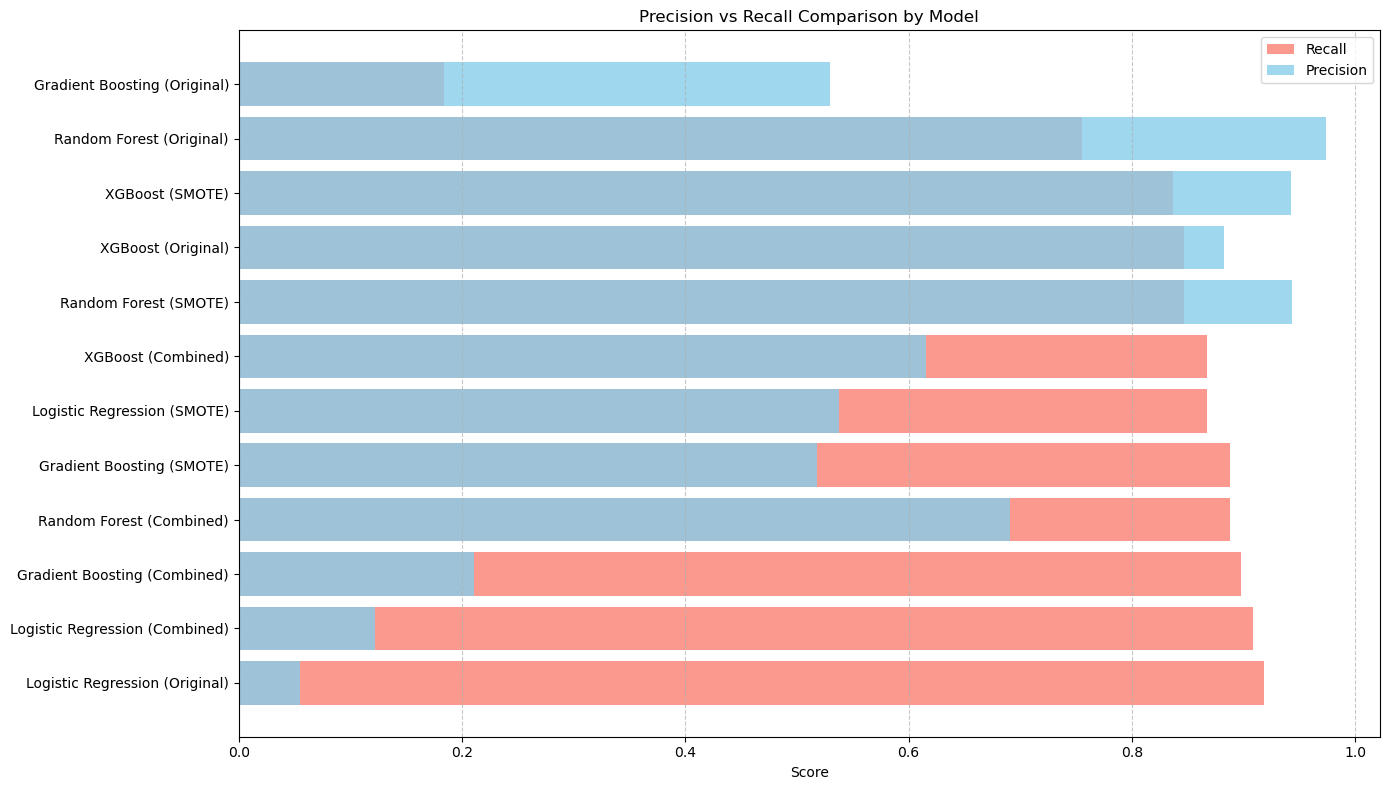

In [21]:
# Metrics visualization
plt.figure(figsize=(14, 8))
plt.barh(metrics_df['Model'], metrics_df['Recall'], color='salmon', alpha=0.8, label='Recall')
plt.barh(metrics_df['Model'], metrics_df['Precision'], color='skyblue', alpha=0.8, label='Precision')
plt.xlabel('Score')
plt.title('Precision vs Recall Comparison by Model')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'model_comparison.png'))
plt.show()

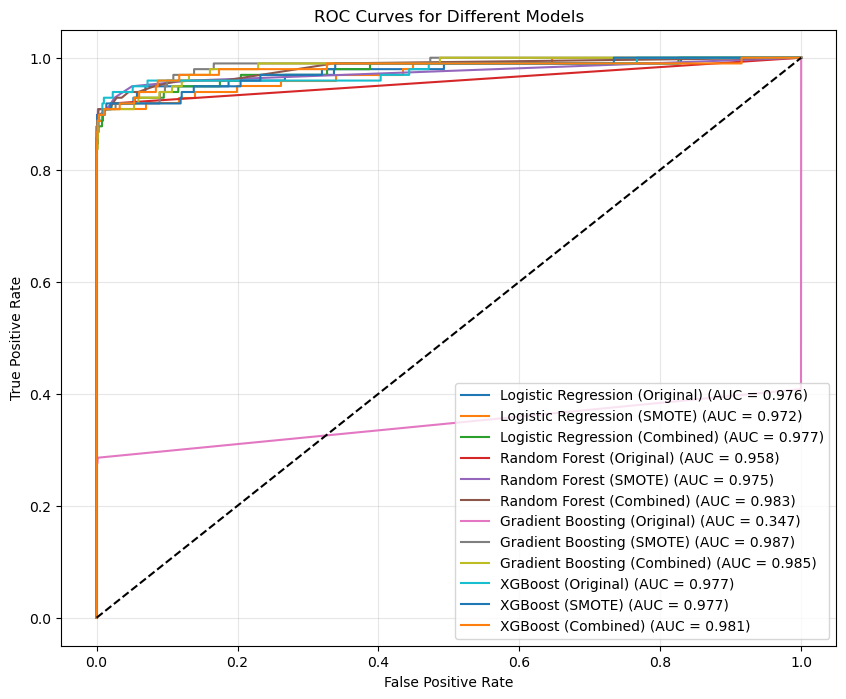

In [23]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(viz_dir, 'roc_curves.png'))
plt.show()

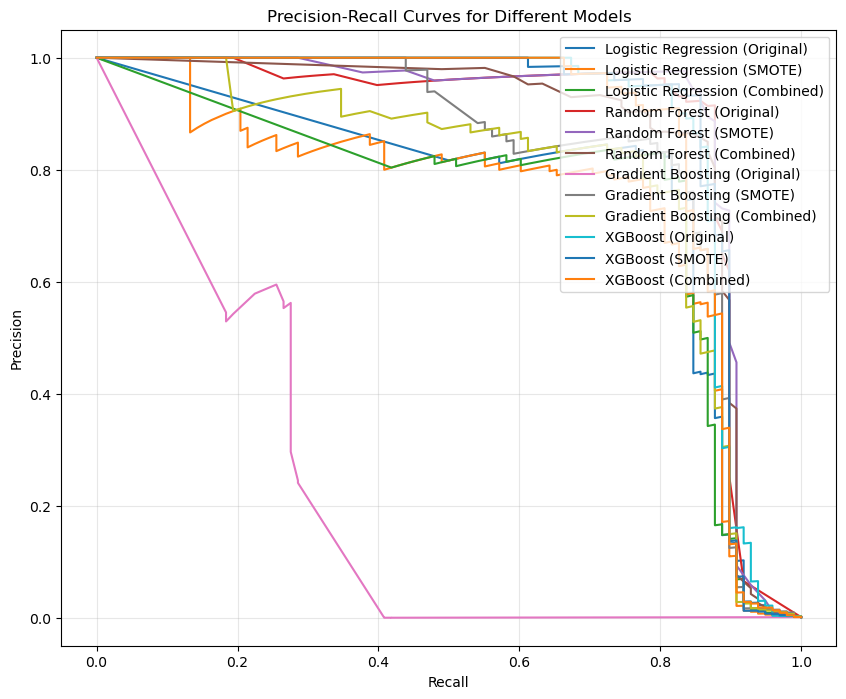

In [25]:
# Precision-Recall curves
plt.figure(figsize=(10, 8))

for model_name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    plt.plot(recall, precision, label=f'{model_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Models')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(viz_dir, 'precision_recall_curves.png'))
plt.show()

In [27]:
# Select the best model (the one with the highest recall)
best_model_name = metrics_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\nThe best model is: {best_model_name}")

# Save the best model
with open(os.path.join(models_dir, 'fraud_detection_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved successfully.")


The best model is: Logistic Regression (Original)
Best model saved successfully.
